In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from my_reviews_loader import BusinessReviewLoader
from my_preprocessor import MyPreProcessor
from feature_engineering import MyFeatureEngineering
from my_sentence_transformer import MySentenceTransformer
from embedding_space_normalizer import EmbeddingSpaceNormalizer
from clustering_evaluator import ClusteringEvaluator
from my_tfidf import MyTFIDF
from theme_extractor import ThemeExtractor

import matplotlib.pyplot as plt
from umap import UMAP

In [2]:
# LOAD REVIEWS
loader = BusinessReviewLoader(
    business_path="yelp_dataset/yelp_academic_dataset_business.json",
    reviews_path="yelp_reviews.parquet"
)

biz_reviews = loader.get_reviews_by_business_name("acme oyster house")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


25/12/14 02:09:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable

✅ Selected Business:
business_id: _ab50qdWOk0DdB6XOrBitw
name: Acme Oyster House
city: New Orleans
state: LA
review_count: 7568
is_open: 1


In [3]:
biz_reviews

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,vHLTOsdILT7xgTu7TAWTUQ,417HF4q8ynnWtuJrkNax_g,_ab50qdWOk0DdB6XOrBitw,5.0,0,0,0,This place has amazing oysters and the BEST bl...,2016-07-25 04:34:34
1,I90lP6oPICTkrhCFGQt5tA,1UAb3zZQeGX6fzZax5DY1A,_ab50qdWOk0DdB6XOrBitw,5.0,0,0,0,OH MY!! A must try. We had no idea there would...,2016-12-19 20:27:16
2,469eAl2fB069YTF_B5zW7w,p2kXD3gNu3N776C0WrmBjA,_ab50qdWOk0DdB6XOrBitw,5.0,0,0,0,The fried seafood was extremely hot. Very nice...,2018-08-23 20:58:39
3,aPpHBDs7Jiiq0sb9YutOhQ,7cDhfvTSH1wTxEmXMj_ChQ,_ab50qdWOk0DdB6XOrBitw,5.0,0,0,0,I love this place. I wish my stay was longer s...,2013-06-24 18:07:12
4,k9OG5kA5ebruSx_f1T-P-A,7QTh-fkw9Nr2lO10-PV8yw,_ab50qdWOk0DdB6XOrBitw,3.0,0,0,0,"Loved the chargrilled oysters! I mean, seriou...",2010-10-06 08:03:20
...,...,...,...,...,...,...,...,...,...
7668,bax2r1CzIbGAFl3s45V2mg,iPKDVi5rk0Tw-Zta7sjzKg,_ab50qdWOk0DdB6XOrBitw,3.0,2,0,1,Came here about 2pm on a rainy Sunday afternoo...,2013-12-27 15:36:07
7669,d5LAa5CvdLyyze89810DWQ,sD6lLERXAWlFz1JbWxW_Pw,_ab50qdWOk0DdB6XOrBitw,5.0,1,0,0,"Once I walked near this place, I knew that I h...",2018-07-01 04:36:45
7670,z-tXUBHlqMtnHbta6rFNDA,jzO1qDO2OP6R_KPml0jdvQ,_ab50qdWOk0DdB6XOrBitw,5.0,5,0,0,Tip- get there just a little early (like right...,2019-07-27 15:26:25
7671,BSkhHEd4bKwuzy4gbU8NFA,xywXoLnG7qWIayFu8oZQgQ,_ab50qdWOk0DdB6XOrBitw,5.0,9,2,9,All I can say about this place is it is one of...,2015-05-20 23:05:09


In [4]:
# PREPROCESS
preprocessor = MyPreProcessor(min_words=3)
clean_reviews = preprocessor.prepare(biz_reviews)

In [5]:
print("Clean Reviews:", clean_reviews.shape)

# pd.set_option("display.max_colwidth", None)

clean_reviews.loc[
    clean_reviews["text_cleaned"].str.contains("jalapeno", case=False, na=False),
    ["text", "text_cleaned"]
].head()

Clean Reviews: (7662, 10)


,text,text_cleaned
151,"I have been to many Acme locations, on many oc...","i have been to many acme locations, on many oc..."
3113,I'm here for work and last night I spent $31 B...,i am here for work and last night i spent $31 ...
7087,This could possibly be a five star joint. But ...,this could possibly be a five star joint. but ...


In [6]:
feature_engineer = MyFeatureEngineering()
fe_reviews = feature_engineer.add_features(clean_reviews)

print("Feature-Engineered Shape:", fe_reviews.shape)
fe_reviews[["text_cleaned", "lemmas", "word_count"]].head()


Feature-Engineered Shape: (7662, 15)


,text_cleaned,lemmas,word_count
0,this place has amazing oysters and the best bl...,place amazing oyster best bloody mary stay nol...,107
1,oh my!! a must try. we had no idea there would...,oh must try idea would line definitely well wo...,82
2,the fried seafood was extremely hot. very nice...,fried seafood extremely hot nice taste add sof...,97
3,i love this place. i wish my stay was longer s...,love place wish stay longer could visit food a...,40
4,"loved the chargrilled oysters! i mean, serious...",loved chargrilled oyster mean seriously never ...,230


In [7]:
# EMBED
embedder = MySentenceTransformer()

X = embedder.encode(
    fe_reviews["text_cleaned"].tolist(),
    batch_size=32,
    normalize_output=True
)

Batches:   0%|          | 0/240 [00:00<?, ?it/s]

/Users/safarifgisa/venvs/python3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


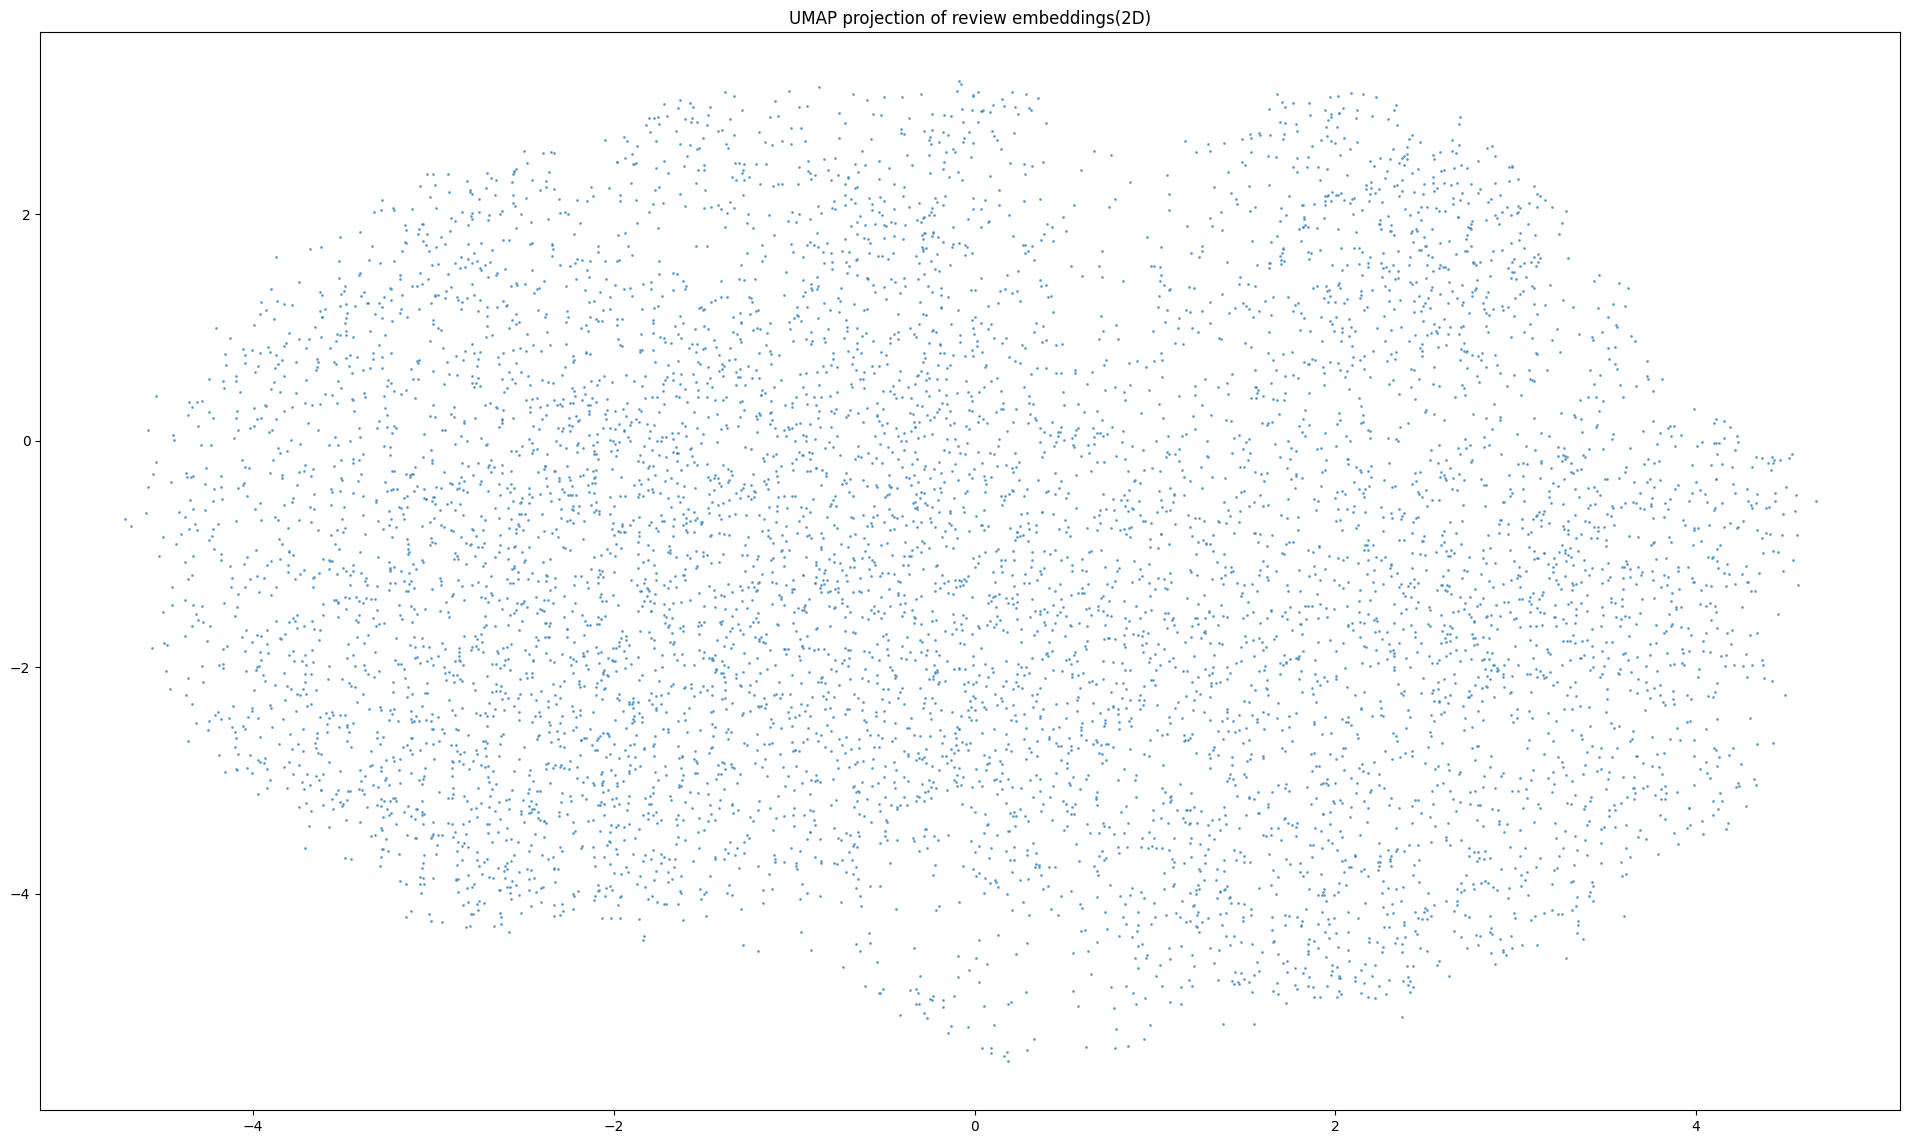

In [8]:
# VISUALIZING THE DATA

# UMAP visualization
reducer = UMAP(n_components=2, n_neighbors=50, min_dist=0.5, random_state=42)

# Reduce to 2D
emb_2d = reducer.fit_transform(X)

# Plot the data
plt.figure(figsize=(24, 14))
sns.scatterplot(x=emb_2d[:, 0], y=emb_2d[:, 1], s=4, alpha=0.8)
plt.title('UMAP projection of review embeddings(2D)')
plt.show()


In [9]:
fe_reviews['normalized_embeddings'] = list(X)

In [10]:
fe_reviews

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,text_cleaned,lemmas,word_count,char_count,avg_word_length,sentence_count,normalized_embeddings
0,vHLTOsdILT7xgTu7TAWTUQ,417HF4q8ynnWtuJrkNax_g,_ab50qdWOk0DdB6XOrBitw,5.0,0,0,0,This place has amazing oysters and the BEST bl...,2016-07-25 04:34:34,this place has amazing oysters and the best bl...,place amazing oyster best bloody mary stay nol...,107,557,4.214953,7,"[0.03673982, -0.014903359, 0.057692226, 0.0146..."
1,I90lP6oPICTkrhCFGQt5tA,1UAb3zZQeGX6fzZax5DY1A,_ab50qdWOk0DdB6XOrBitw,5.0,0,0,0,OH MY!! A must try. We had no idea there would...,2016-12-19 20:27:16,oh my!! a must try. we had no idea there would...,oh must try idea would line definitely well wo...,82,425,4.195122,12,"[-0.05602528, 0.02408532, 0.048665505, 0.03703..."
2,469eAl2fB069YTF_B5zW7w,p2kXD3gNu3N776C0WrmBjA,_ab50qdWOk0DdB6XOrBitw,5.0,0,0,0,The fried seafood was extremely hot. Very nice...,2018-08-23 20:58:39,the fried seafood was extremely hot. very nice...,fried seafood extremely hot nice taste add sof...,97,530,4.474227,16,"[-0.017265098, 0.015360626, 0.031241767, 0.011..."
3,aPpHBDs7Jiiq0sb9YutOhQ,7cDhfvTSH1wTxEmXMj_ChQ,_ab50qdWOk0DdB6XOrBitw,5.0,0,0,0,I love this place. I wish my stay was longer s...,2013-06-24 18:07:12,i love this place. i wish my stay was longer s...,love place wish stay longer could visit food a...,40,193,3.850000,5,"[0.014109538, -0.015697045, 0.0726448, 0.06472..."
4,k9OG5kA5ebruSx_f1T-P-A,7QTh-fkw9Nr2lO10-PV8yw,_ab50qdWOk0DdB6XOrBitw,3.0,0,0,0,"Loved the chargrilled oysters! I mean, seriou...",2010-10-06 08:03:20,"loved the chargrilled oysters! i mean, serious...",loved chargrilled oyster mean seriously never ...,230,1277,4.556522,17,"[0.0054590553, 0.011540222, 0.111951835, 0.001..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7657,bax2r1CzIbGAFl3s45V2mg,iPKDVi5rk0Tw-Zta7sjzKg,_ab50qdWOk0DdB6XOrBitw,3.0,2,0,1,Came here about 2pm on a rainy Sunday afternoo...,2013-12-27 15:36:07,came here about 2pm on a rainy sunday afternoo...,came rainy sunday afternoon seated right away ...,144,768,4.340278,15,"[-0.035424817, -0.004527867, 0.1364295, 0.0328..."
7658,d5LAa5CvdLyyze89810DWQ,sD6lLERXAWlFz1JbWxW_Pw,_ab50qdWOk0DdB6XOrBitw,5.0,1,0,0,"Once I walked near this place, I knew that I h...",2018-07-01 04:36:45,"once i walked near this place, i knew that i h...",walked near place knew eat wish took picture l...,70,326,3.671429,8,"[0.016688742, 0.058547273, 0.03478674, 0.03825..."
7659,z-tXUBHlqMtnHbta6rFNDA,jzO1qDO2OP6R_KPml0jdvQ,_ab50qdWOk0DdB6XOrBitw,5.0,5,0,0,Tip- get there just a little early (like right...,2019-07-27 15:26:25,tip- get there just a little early (like right...,get little early like right wait came town ask...,126,644,4.119048,16,"[0.059584104, 0.035370685, 0.09385676, 0.02421..."
7660,BSkhHEd4bKwuzy4gbU8NFA,xywXoLnG7qWIayFu8oZQgQ,_ab50qdWOk0DdB6XOrBitw,5.0,9,2,9,All I can say about this place is it is one of...,2015-05-20 23:05:09,all i can say about this place is it is one of...,say place one top place eat know amazingly goo...,108,555,4.148148,28,"[0.058236513, -0.0003620912, 0.10090795, 0.020..."


#### The curse of dimansionality

In [11]:
# Fix embedding space geometry
# normalizer = EmbeddingSpaceNormalizer(n_components=10, whiten=True)
# X_white = normalizer.fit_transform(X)
# print("Variance retained:", normalizer.variance_retained())

In [30]:
umap = UMAP(
    n_components=10,
    n_neighbors=15,
    min_dist=0.05,
    random_state=42
)
X_umap = umap.fit_transform(X)

/Users/safarifgisa/venvs/python3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [31]:
# find best k, cluster, and evaluate
evaluator = ClusteringEvaluator(random_state=42)

results_df = evaluator.evaluate_k_range(
    X_raw=X_umap,
    X_white=X_umap,
    k_values=range(2, 10)
)

Evaluating k=2...
Evaluating k=3...
Evaluating k=4...
Evaluating k=5...
Evaluating k=6...
Evaluating k=7...
Evaluating k=8...
Evaluating k=9...


In [32]:
results_df.sort_values(
    by=["avg_intra_cosine", "inter_centroid_cosine"],
    ascending=[False, True]
)

,k,avg_intra_cosine,inter_centroid_cosine,cluster_size_std
7,9,0.998646,0.991802,239.154065
6,8,0.998518,0.991403,298.784517
5,7,0.998277,0.991516,236.038651
4,6,0.998085,0.991268,379.173663
3,5,0.997680,0.991072,503.557186
2,4,0.997099,0.990260,742.080016
1,3,0.996605,0.989774,1483.349588
0,2,0.995788,0.991184,561.000000


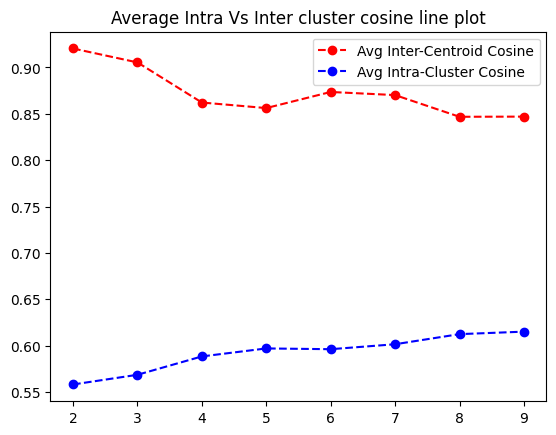

In [14]:
plt.plot(results_df['k'], results_df['inter_centroid_cosine'], marker='o', linestyle='--', c='red', label='Avg Inter-Centroid Cosine')
plt.plot(results_df['k'], results_df['avg_intra_cosine'], marker='o', linestyle='--', c='blue', label='Avg Intra-Cluster Cosine')
plt.title('Average Intra Vs Inter cluster cosine line plot')
plt.legend()
plt.show()

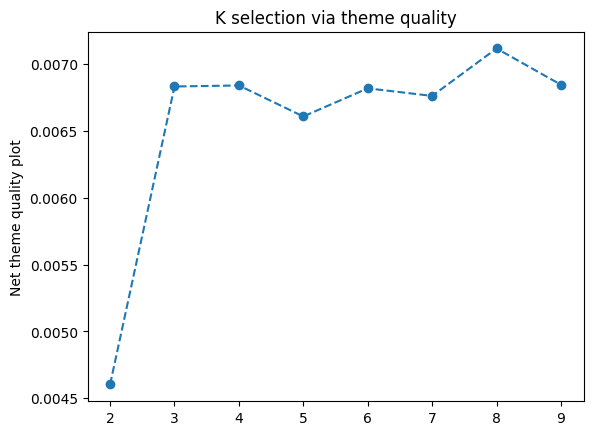

In [33]:
# Net theme quality
plt.plot(results_df['k'], results_df['avg_intra_cosine'] - results_df['inter_centroid_cosine'], marker='o', linestyle='--')
plt.ylabel('Net theme quality plot')
plt.title("K selection via theme quality")
plt.show()

In [34]:
# select best k; true geometric elbow
def select_k(results_df):
    """
    Choose k using elbow on net theme quality curve:
    net = intra_cluster_cosine - inter_centroid_cosine
    """
    df = results_df.copy().sort_values('k')

    k_vals = df["k"].values
    net_qual = (df["avg_intra_cosine"] - df["inter_centroid_cosine"]).values

    # Normalize
    k_norm = (k_vals - k_vals.min()) / (k_vals.max() - k_vals.min())
    net_norm = (net_qual - net_qual.min()) / (net_qual.max() - net_qual.min())

    p1 = np.array([k_norm[0], net_norm[0]])
    p2 = np.array([k_norm[-1], net_norm[-1]])
    line_vec = p2 - p1
    line_len = np.linalg.norm(line_vec)

    distances = []
    for x, y in zip(k_norm, net_norm):
        p = np.array([x, y])
        dist = np.abs(
            line_vec[1] * (p[0] - p1[0]) -
            line_vec[0] * (p[1] - p1[1])
        ) / line_len
        distances.append(dist)

    distances = np.array(distances)
    distances[0] = 0
    distances[-1] = 0

    best_idx = distances.argmax()
    best_k = int(k_vals[best_idx])

    return best_k, distances

In [35]:
best_k, elbow_distances = select_k(results_df)
print(f"Auto selected k: {best_k}")
print(f"Elbow distances: {elbow_distances}")

Auto selected k: 3
Elbow distances: [0.         0.56672022 0.47392478 0.30996992 0.27732279 0.16542064
 0.17567398 0.        ]


In [37]:
# Fit with best_k
kmeans, labels = evaluator.fit_final_clustering(X_umap, best_k)

In [38]:
labels.shape

(7662,)

In [39]:
# Assign clusters
reviews_df = fe_reviews.copy()
reviews_df['cluster'] = labels

In [40]:
reviews_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,text_cleaned,lemmas,word_count,char_count,avg_word_length,sentence_count,normalized_embeddings,cluster
0,vHLTOsdILT7xgTu7TAWTUQ,417HF4q8ynnWtuJrkNax_g,_ab50qdWOk0DdB6XOrBitw,5.0,0,0,0,This place has amazing oysters and the BEST bl...,2016-07-25 04:34:34,this place has amazing oysters and the best bl...,place amazing oyster best bloody mary stay nol...,107,557,4.214953,7,"[0.03673982, -0.014903359, 0.057692226, 0.0146...",0
1,I90lP6oPICTkrhCFGQt5tA,1UAb3zZQeGX6fzZax5DY1A,_ab50qdWOk0DdB6XOrBitw,5.0,0,0,0,OH MY!! A must try. We had no idea there would...,2016-12-19 20:27:16,oh my!! a must try. we had no idea there would...,oh must try idea would line definitely well wo...,82,425,4.195122,12,"[-0.05602528, 0.02408532, 0.048665505, 0.03703...",1
2,469eAl2fB069YTF_B5zW7w,p2kXD3gNu3N776C0WrmBjA,_ab50qdWOk0DdB6XOrBitw,5.0,0,0,0,The fried seafood was extremely hot. Very nice...,2018-08-23 20:58:39,the fried seafood was extremely hot. very nice...,fried seafood extremely hot nice taste add sof...,97,530,4.474227,16,"[-0.017265098, 0.015360626, 0.031241767, 0.011...",2
3,aPpHBDs7Jiiq0sb9YutOhQ,7cDhfvTSH1wTxEmXMj_ChQ,_ab50qdWOk0DdB6XOrBitw,5.0,0,0,0,I love this place. I wish my stay was longer s...,2013-06-24 18:07:12,i love this place. i wish my stay was longer s...,love place wish stay longer could visit food a...,40,193,3.850000,5,"[0.014109538, -0.015697045, 0.0726448, 0.06472...",2
4,k9OG5kA5ebruSx_f1T-P-A,7QTh-fkw9Nr2lO10-PV8yw,_ab50qdWOk0DdB6XOrBitw,3.0,0,0,0,"Loved the chargrilled oysters! I mean, seriou...",2010-10-06 08:03:20,"loved the chargrilled oysters! i mean, serious...",loved chargrilled oyster mean seriously never ...,230,1277,4.556522,17,"[0.0054590553, 0.011540222, 0.111951835, 0.001...",1


In [41]:
# Create TF-IDF matrix and extract cluster local top_n top terms
tfidf = MyTFIDF(max_features=8000)

tf_df = tfidf.build_global(reviews_df["text_cleaned"]) # used lemmas before

# cluster_terms_global = tfidf.extract_cluster_terms(
#     tf_df=tf_df,
#     labels=labels,
#     top_n=12
# )

cluster_terms = tfidf.extract_cluster_terms_contrastive(
    tf_df=tf_df,
    labels=labels,
    top_n=12
)

In [42]:
for k,v in cluster_terms.items():
    print(f"cluster {k}: {v}")

cluster 0: ['nola', 'place', 'chargrilled', 'time', 'best', 'chargrilled oysters', 'acme', 'visit', 'line', 'definitely', 'trip', 'wait']
cluster 1: ['good', 'great', 'food', 'wait', 'service', 'chargrilled', 'line', 'chargrilled oysters', 'worth', 'place', 'amazing', 'shrimp']
cluster 2: ['new', 'orleans', 'new orleans', 'acme', 'oyster', 'place', 'house', 'time', 'line', 'good', 'best', 'acme oyster']


In [43]:
# Load .env
from dotenv import load_dotenv
load_dotenv()

True

In [44]:
# Create connect to OPENAI API
from openai import OpenAI
client = OpenAI()

In [45]:
# Extract cluster representaticve reviews and generate theme cards
theme_extractor = ThemeExtractor(client)

# Extract representative examples
cluster_examples = evaluator.extract_representative_examples(
    X_white=X_white,      
    df=reviews_df,
    labels=labels,
    kmeans_model=kmeans,
    text_col="text_cleaned",
    top_n=10
)

themes = theme_extractor.generate_all_themes(
    cluster_terms=cluster_terms,
    cluster_examples=cluster_examples
)


In [46]:
themes

{0: {'theme_name': 'Oysters and Service',
  'summary': 'Customers rave about the chargrilled oysters and attentive service, making it a top choice in NOLA.',
  'likes': ['Fresh and delicious chargrilled oysters',
   'Attentive and helpful staff'],
  'dislikes': ['Inconsistent quality of some dishes',
   'Long wait times during busy periods'],
  'business_impact': 'Positive reviews can drive repeat visits and attract new customers.'},
 1: {'theme_name': 'Mixed Dining Experience',
  'summary': 'Customers appreciate the chargrilled oysters and some dishes but express dissatisfaction with service and certain food items.',
  'likes': ['chargrilled oysters', 'great service'],
  'dislikes': ['slow service', 'mediocre food'],
  'business_impact': 'Improving service speed and food quality could enhance customer satisfaction and retention.'},
 2: {'theme_name': 'Acme Oyster House Experience',
  'summary': 'Customers rave about the chargrilled oysters and overall food quality, but some find the s

In [47]:
# Compare NON-contrastive vs contrastive for one cluster
cid = 0

global_top = (
    tf_df[labels == cid]
    .mean(axis=0)
    .sort_values(ascending=False)
    .head(15)
)

contrastive_top = cluster_terms[cid]

print("GLOBAL TOP:")
print(global_top.index.tolist())

print("\nCONTRASTIVE TOP:")
print(contrastive_top)


GLOBAL TOP:
['nola', 'place', 'chargrilled', 'good', 'line', 'chargrilled oysters', 'wait', 'best', 'food', 'great', 'time', 'acme', 'oyster', 'just', 'definitely']

CONTRASTIVE TOP:
['nola', 'place', 'chargrilled', 'time', 'best', 'chargrilled oysters', 'acme', 'visit', 'line', 'definitely', 'trip', 'wait']
